In [1]:
%load_ext autoreload
%autoreload 2

## Apprentissage des aspect implicites

### Importation des bibliothèques

In [2]:
import os
os.chdir("..")

In [3]:
import copy
import numpy as np
from itertools import chain
from collections import Counter
import seaborn as sns
from collections import Counter
from time import time
from Preprocessors.ReviewPreprocessor import ReviewPreprocessor
from Aspects.ExplicitAspectExtractor import ExplicitAspectExtractor
from Aspects.CoRefAspectIdentGrouping import CoRefAspectIdentGrouping
from Aspects.ImplicitAspectExtractor import ImplicitAspectExtractor
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

### Fonction de pretraitement des datasets

La fonction prend un dictionnaire de datasets. Le dictionnaire a comme clé un nom pour identifier le dataset et comme valeur le chemin vers le dataset.

In [4]:
def clean_datasets(datasets):
    cleaned_datasets = []
    for dataset_name in datasets:
        print(f"cleaning dataset {dataset_name}")
        dataset = pd.read_csv(datasets[dataset_name])
        old = time()
        review_preprocessor = ReviewPreprocessor(dataset['review'], nlp)
        dataset['cleaned_review'] = review_preprocessor.remove_tags()
        dataset['cleaned_review'] = review_preprocessor.lowercase_transformation()
        dataset['cleaned_review'] = review_preprocessor.pararel_spelling_correction()
        dataset['cleaned_review'] = review_preprocessor.remove_objective_sentences()
        dataset = dataset[dataset['cleaned_review'] != ""]
        print(f"cleaning {dataset_name} took {time() - old}")
        cleaned_datasets.append((dataset_name, dataset))
    return cleaned_datasets

### Fonction d'extraction des apsects

In [5]:
def extract_aspects(cleaned_datasets, aspects_threshold = 50):
    result = []
    for cleaned_dataset in cleaned_datasets:
        print(f"extracting aspects from {cleaned_dataset[0]}")
        old = time()
        explicit_aspect_extractor = ExplicitAspectExtractor(cleaned_dataset[1]['cleaned_review'], nlp)
        explicit_aspect_extractor.extract_aspects()
        frequent_aspects = explicit_aspect_extractor.get_frequent_aspects(aspects_threshold)
        result.append((cleaned_dataset[0], frequent_aspects))
        print(f"duration took for extracting explicit aspects and convert to probability {time() - old}")
    return result

### Application de prétraitement

Les jeux de données utilisés dans cette notebook sont collectés à l'aide de module de scraping créé pour le projet.

- les datasets **tripadvisor**, **booking** et **agoda** contient des commentaires de 10 hôtels à Paris, en total chaque dataset contient respectivement 2141, 1022, 230 commentaires.
- les datasets **agoda_london** et **tripadivsor_london** contient des commentaires de 5 hôtels à Londres, en total chaque dataset contient respectivement 245 et 658.

In [6]:
old = time()
datasets = {'tripadvisor': 'data/3 datasets/reviews_TripAdvisor_2022_5_20_11_27_56_ 10pages_10hotels.csv',
                    'booking': 'data/3 datasets/reviews_Booking_2022_5_20_11_9_54_10links_10_pages.csv',
                    'agoda': 'data/3 datasets/reviews_Agoda_2022_5_20_10_58_5_10pages_10_links.csv',
                    'agoda_london':'data/3 datasets/reviews_Agoda_2022_5_21_11_32_11_London_5pages_5links.csv',
                    'tripadvisor_london': 'data/3 datasets/reviews_TripAdvisor_2022_5_21_11_51_26_london_5pages_5links.csv'}
cleaned_datasets = clean_datasets(datasets)
print(f"duration : {time() - old}")

cleaning dataset tripadvisor


2141it [00:53, 40.20it/s]


cleaning tripadvisor took 216.7631106376648
cleaning dataset booking


1022it [00:12, 78.85it/s]


cleaning booking took 33.0648980140686
cleaning dataset agoda


230it [00:03, 76.10it/s]


cleaning agoda took 14.016721487045288
cleaning dataset agoda_london


245it [00:04, 60.93it/s]


cleaning agoda_london took 21.253764629364014
cleaning dataset tripadvisor_london


658it [00:17, 38.70it/s]

cleaning tripadvisor_london took 64.01032400131226
duration : 349.1975073814392


### Application d'extraction des aspects explicites.

In [7]:
all_aspects_prob_freq = extract_aspects(cleaned_datasets)

extracting aspects from tripadvisor
duration took for extracting explicit aspects and convert to probability 32.59034705162048
extracting aspects from booking
duration took for extracting explicit aspects and convert to probability 7.825596570968628
extracting aspects from agoda
duration took for extracting explicit aspects and convert to probability 1.7369139194488525
extracting aspects from agoda_london
duration took for extracting explicit aspects and convert to probability 2.261775016784668
extracting aspects from tripadvisor_london
duration took for extracting explicit aspects and convert to probability 10.153979778289795


### Construction de la matrice de co-occurrence pour chaque dataset

In [8]:
co_occurrence_matrixes = []
for i, cleaned_d in enumerate(cleaned_datasets):
    print(f"creating cooccurrence matrix for {cleaned_d[0]}")
    cleaned_d[1].rename(columns = {'cleaned_data':'cleaned_review'}, inplace= True)
    co_ref_obj = CoRefAspectIdentGrouping(cleaned_d[1], dict(all_aspects_prob_freq[i][1]), nlp)
    old = time()
    co_occurrence_matrix = co_ref_obj.get_co_occurrence_matrix()
    co_occurrence_matrixes.append((cleaned_d[0], co_occurrence_matrix))
    print(f"duration to construct co-occurence matrix of {cleaned_d[0]} dataset is {time() - old}s")

creating cooccurrence matrix for tripadvisor
duration to construct co-occurence matrix of tripadvisor dataset is 62.22526693344116s
creating cooccurrence matrix for booking
duration to construct co-occurence matrix of booking dataset is 12.324040174484253s
creating cooccurrence matrix for agoda
duration to construct co-occurence matrix of agoda dataset is 2.7814230918884277s
creating cooccurrence matrix for agoda_london
duration to construct co-occurence matrix of agoda_london dataset is 3.717524528503418s
creating cooccurrence matrix for tripadvisor_london
duration to construct co-occurence matrix of tripadvisor_london dataset is 17.85344409942627s


In [9]:
shared_aspects = set.intersection(set(co_occurrence_matrixes[0][1].columns),
                                  set(co_occurrence_matrixes[1][1].columns),
                                  set(co_occurrence_matrixes[2][1].columns),
                                  set(co_occurrence_matrixes[3][1].columns),
                                  set(co_occurrence_matrixes[4][1].columns))
len(shared_aspects)

45

il a 45 aspects explicites communs entre les cinq dataset

#### les adjectifs partagés entre les matrices de cooccurrences

In [10]:
len(set.intersection(set(co_occurrence_matrixes[0][1].index), set(co_occurrence_matrixes[1][1].index), set(co_occurrence_matrixes[2][1].index), set(co_occurrence_matrixes[3][1].index), set(co_occurrence_matrixes[4][1].index)))

110

Il y a 110 adjectifs communs entre les 5 matrices de cooccurrences. Ce nombre est bas car il est influencé par les datasets avec moins d'adjectifs.

#### les adjectifs non partagés entre les matrices de cooccurrences.

In [11]:
adjs = [set(co_occurrence_matrixes[0][1].index),
        set(co_occurrence_matrixes[1][1].index),
        set(co_occurrence_matrixes[2][1].index),
        set(co_occurrence_matrixes[3][1].index),
        set(co_occurrence_matrixes[4][1].index)]

freq = Counter(chain.from_iterable(adjs))

res = {idx for idx in freq if freq[idx] == 1}

In [12]:
len(res)

867

il y a 867 adjectifs non partagé (existe dans une seul matrice, mais n'est pas dans les autres).

#### Porcentage des adjs non partagé dans chaque dataset

In [13]:
len(res & set(co_occurrence_matrixes[0][1].index)) / len(res) * 100

68.62745098039215

68.63% des adjs non partagés sont dans le dataset **tripadvisor** qui contient 2141 commentaires.

In [14]:
len(res & set(co_occurrence_matrixes[1][1].index)) / len(res) * 100

7.035755478662054

Le dataset **booking** (1022 commentaires) contient 7% des adjs non partagés.

In [15]:
len(res & set(co_occurrence_matrixes[2][1].index)) / len(res) * 100

1.4994232987312572

1.5% des adjectifs non partagés sont dans le dataset **agoda** qui contient 230 commentaires.

In [16]:
len(res & set(co_occurrence_matrixes[3][1].index)) / len(res) * 100

4.036908881199539

Le jeu de données **agoda_london** (245 commentaires) participe avec un pourcentage de 4% dans la liste des adjectifs non partagés.

In [17]:
len(res & set(co_occurrence_matrixes[4][1].index)) / len(res) * 100

18.800461361014996

Le jeu de données **tripadvisor_london** contient 18.8% des adjs non partagés.

### Calcule des proportions

la relation utilisé pour calculer les proportions de chaque aspect dans un adjectif est:

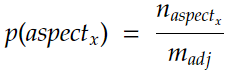

avec:
- **n** nombre d'occurence de l'aspect 
- **m** le nombre d'occurence de l'adjective

In [18]:
prop_matrixes = copy.deepcopy(co_occurrence_matrixes)
for i in range(0,5):
    matrix = prop_matrixes[i][1]
    for adj in list(matrix.index):
        occurences_sum = matrix.loc[adj].sum(axis=0)
        for aspect in list(matrix.columns):
            matrix.loc[adj, aspect] = matrix.at[adj, aspect]/occurences_sum

jeu de données **tripadvisor**

In [19]:
prop_matrixes[0][1]*100

,hotel,room,staff,breakfast,location,day,restaurant,stay,night,area,...,afternoon,size,price,morning,trip,tea,choice,door,lobby,shop
small,11.301637,28.994544,2.961808,3.273578,2.0265,1.325019,1.870616,1.01325,0.935308,1.792673,...,0.233827,2.727981,0.701481,0.623539,0.701481,0.545596,0.623539,0.545596,0.779423,0.857366
comfortable,8.592911,26.852846,5.155747,3.544576,2.792696,1.288937,0.966702,2.36305,2.255639,1.181525,...,0.214823,1.396348,0.107411,0.0,0.429646,0.214823,0.322234,0.429646,0.75188,0.214823
hot,5.185185,9.876543,1.975309,10.123457,0.740741,6.666667,0.493827,0.987654,4.197531,1.234568,...,1.728395,0.0,0.0,1.975309,0.0,1.234568,2.222222,1.234568,1.234568,0.0
good,11.091234,9.552773,5.509839,11.198569,8.336315,2.397138,3.756708,1.395349,1.395349,1.896243,...,0.429338,1.57424,1.395349,0.465116,0.572451,0.608229,1.144902,0.644007,0.465116,1.109123
simple,5.128205,10.25641,2.564103,23.076923,7.692308,0.0,2.564103,2.564103,0.0,2.564103,...,2.564103,0.0,0.0,0.0,0.0,0.0,0.0,2.564103,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
linger,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ambient,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
minimalistic,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
overgrown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


jeu de données **booking**

In [20]:
prop_matrixes[1][1]*100

,room,hotel,staff,breakfast,location,restaurant,day,stay,night,bed,...,door,size,bit,morning,garden,afternoon,choice,tea,trip,experience
pathetic,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
faulty,16.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.666667,...,16.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
few,10.638298,14.893617,2.12766,4.255319,4.255319,4.255319,6.382979,0.0,2.12766,4.255319,...,0.0,0.0,6.382979,0.0,0.0,0.0,2.12766,2.12766,0.0,0.0
fantastic,0.0,11.111111,22.222222,11.111111,11.111111,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,11.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0
great,13.084112,5.140187,9.813084,8.411215,21.495327,2.803738,0.934579,0.46729,1.869159,3.271028,...,0.934579,0.0,0.0,0.934579,0.0,0.0,0.46729,0.0,0.46729,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
accommodating,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
blue,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sensitive,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
essential,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


jeu de données **agoda**

In [21]:
prop_matrixes[2][1]*100

,room,hotel,staff,breakfast,location,restaurant,day,stay,night,bed,...,bit,door,size,morning,garden,airport,experience,afternoon,tea,choice
professional,0.0,0.0,33.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
first,11.111111,11.111111,5.555556,0.0,0.0,0.0,5.555556,0.0,5.555556,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
friendly,9.090909,12.121212,57.575758,3.030303,3.030303,3.030303,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
important,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nice,13.333333,11.111111,24.444444,4.444444,8.888889,2.222222,2.222222,2.222222,2.222222,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sleepless,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,25.0,...,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cooperative,50.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
quiet,16.666667,0.0,16.666667,0.0,16.666667,0.0,0.0,16.666667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
stuffy,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0


jeu de données **agoda_london**

In [22]:
prop_matrixes[3][1]*100

,room,hotel,staff,breakfast,location,restaurant,night,stay,day,bed,...,bit,door,morning,size,airport,garden,experience,afternoon,tea,check
terrible,12.5,25.0,6.25,6.25,0.0,6.25,6.25,0.0,0.0,6.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bad,8.333333,29.166667,0.0,0.0,8.333333,4.166667,8.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.166667,0.0,0.0,0.0
horrendous,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
naked,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
drunk,25.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
intrusive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
extra,33.333333,33.333333,0.0,0.0,0.0,0.0,0.0,0.0,33.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eld,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,...,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unhelpful,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,...,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


jeu de données **tripadvisor_london**

In [23]:
prop_matrixes[4][1]*100

,room,hotel,staff,breakfast,location,stay,night,bed,restaurant,service,...,bit,door,distance,morning,check,size,garden,tea,trip,choice
lovely,14.662757,14.076246,10.26393,4.398827,4.692082,3.812317,0.58651,2.932551,1.466276,2.639296,...,0.879765,0.293255,0.0,0.0,0.58651,0.879765,1.173021,1.759531,0.0,0.293255
quiet,27.027027,8.108108,4.054054,0.0,5.405405,4.054054,6.756757,6.756757,0.0,1.351351,...,1.351351,0.0,1.351351,0.0,1.351351,0.0,0.0,0.0,0.0,0.0
efficient,10.344828,10.344828,17.241379,0.0,6.896552,0.0,0.0,0.0,6.896552,6.896552,...,0.0,6.896552,3.448276,0.0,10.344828,0.0,0.0,0.0,0.0,0.0
friendly,7.580175,11.370262,39.358601,3.498542,4.081633,2.332362,1.166181,0.0,1.457726,4.081633,...,0.291545,0.0,0.0,0.874636,2.915452,0.291545,0.58309,0.0,0.291545,0.0
quick,5.0,30.0,5.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
following,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
canary,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
brown,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
seperate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
all_aspects = set.union(set(co_occurrence_matrixes[0][1].columns), set(co_occurrence_matrixes[1][1].columns), set(co_occurrence_matrixes[2][1].columns), set(co_occurrence_matrixes[3][1].columns), set(co_occurrence_matrixes[4][1].columns))

In [25]:
shared_aspects = set.intersection(set(co_occurrence_matrixes[0][1].columns), set(co_occurrence_matrixes[1][1].columns), set(co_occurrence_matrixes[2][1].columns), set(co_occurrence_matrixes[3][1].columns), set(co_occurrence_matrixes[4][1].columns))

In [26]:
shared_adjs = set.intersection(set(co_occurrence_matrixes[0][1].index), set(co_occurrence_matrixes[1][1].index), set(co_occurrence_matrixes[2][1].index), set(co_occurrence_matrixes[3][1].index), set(co_occurrence_matrixes[4][1].index))

### Calcule de variance pour les couples (adjectif, aspect)

Dans cette partie, nous calculons la variance entre les proportions des couple (adjectif, aspect) dans les cinq datasets.

In [27]:
variance_adjs_aspects_matrixes = pd.DataFrame(index=shared_adjs, columns=shared_aspects)
for shared_adj in shared_adjs:
    for aspect in all_aspects:
        values = np.array([])
        for prop_matrix in prop_matrixes:
            try:
                values = np.append(values, prop_matrix[1].loc[shared_adj, aspect]*100)
            except KeyError:
                values = np.append(values, 0)
        variance_adjs_aspects_matrixes.loc[shared_adj, aspect] = values.var()

In [28]:
variance_adjs_aspects_matrixes

,tower,snack,reception,window,night,food,restaurant,water,area,shower,...,place,trip,afternoon,check,lobby,bit,choice,experience,airport,shop
available,0.007936,18.284161,6.5394,0.007936,0.507934,1.290389,9.607622,2.239358,9.600003,3.024575,...,0.007936,0.000000,4.198392,2.560000,0.793647,0.000000,2.401906,0.000000,0.000000,0.126983
hot,0.519438,1.404664,0.624652,8.945388,26.070044,10.285408,0.458617,141.672925,0.284747,29.898865,...,0.039018,0.129860,0.477976,0.591716,0.243865,0.147929,2.473227,0.000000,0.000000,0.000000
hard,0.0,0.0,0.0,11.111111,2.938776,0.0,0.326531,18.82716,0.326531,4.948098,...,0.0,2.777778,0.000000,0.000000,0.000000,2.777778,0.000000,100.000000,0.000000,0.000000
fine,0.078243,0.312974,0.078243,0.704191,149.94826,1.157411,4.243861,0.312974,170.409854,4.318844,...,10.491684,0.000000,0.000000,1.234568,0.000000,1.234568,0.000000,0.000000,11.111111,0.000000
amazing,2.89606,0.082416,0.036629,0.036629,1.791116,17.663172,14.70276,0.221453,0.416019,0.832378,...,0.786379,0.213050,0.036629,0.055363,0.036629,0.055363,2.707190,20.060660,0.000000,0.228932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
basic,0.0,0.444444,0.444444,0.0,12.576676,0.0,1.777778,0.0,1.777778,6.666667,...,0.444444,0.000000,0.000000,0.000000,0.444444,0.000000,0.444444,0.000000,0.000000,0.444444
least,12.420526,0.569598,31.066325,12.420526,5.876201,6.25,0.569598,0.569598,12.757106,1524.598913,...,0.569598,0.000000,0.569598,0.000000,0.569598,32.653061,0.000000,0.000000,0.000000,0.000000
busy,0.237954,0.237954,1572.87329,1554.453313,4.241597,23.51279,0.8764,0.0,21.633315,0.0,...,23.51279,0.876400,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000
long,0.0,1.940546,60.306021,1.234595,4.227865,4.262257,0.039603,5.481529,4.227865,5.563097,...,1.260373,2.853423,0.356427,0.000000,0.356427,0.724310,0.039603,0.000000,0.000000,0.039603


#### vérification de calcule de variance

Pour vérifier le calcule de variance, nous choissons le coupe (nice, hotel).

**la variance calculé par le code ci-dessus**

In [29]:
variance_adjs_aspects_matrixes.loc['nice','hotel']

3.063454529243125

**proportion de couple (nice, hotel) dans les cinq dataset**

In [30]:
for i in range(0,5):
    print("dataset :", prop_matrixes[i][0], "/ proportion : ", prop_matrixes[i][1].loc['nice', 'hotel']*100)

dataset : tripadvisor / proportion :  13.765373699148533
dataset : booking / proportion :  9.541984732824428
dataset : agoda / proportion :  11.11111111111111
dataset : agoda_london / proportion :  14.285714285714285
dataset : tripadvisor_london / proportion :  12.755102040816327


In [31]:
np.array([13.765373699148533, 9.541984732824428, 11.11111111111111,14.285714285714285,12.755102040816327]).var()

3.063454529243125

**La valeur calculée ci-dessus est égale à celle calculée par le code dans la cellule 29.**

In [32]:
stacked_variance = variance_adjs_aspects_matrixes.stack()

In [33]:
stacked_variance.sort_values(ascending=False)

underground  location      2083.677686
awful        location           1600.0
overall      day           1589.617778
worth        location      1573.899661
busy         reception      1572.87329
                              ...     
french       bit                   0.0
             choice                0.0
old          morning               0.0
french       experience            0.0
delicious    shop                  0.0
Length: 5940, dtype: object

In [34]:
len(stacked_variance[stacked_variance ==0].index)

1649

Il y a 1649 couples (adjectif, aspect) ont une variance égale à zéro.

**Remarques**

- les éléments avec une grande variance comme le couple ('underground', 'location'). ils ont des proportions dispersées.

In [35]:
np.array([9.090909090909091,100,100,12.5,0]).var()

2083.6776859504134

In [36]:
np.array([3.6585365853658534,0,0,100,0]).var()

1572.8732897085067

- les couples (adjectifs, aspects) qui ont une petite variance ont des valeurs de proportion proches entre eux ou proches de zéro. 

In [37]:
variance_adjs_aspects_matrixes.loc['clean','room']

2.269700722435791

In [38]:
for i in range(0,5):
    print("dataset :", prop_matrixes[i][0], "/ proportion :", prop_matrixes[i][1].loc['clean', 'room']*100)

dataset : tripadvisor / proportion : 28.673408685306367
dataset : booking / proportion : 31.645569620253166
dataset : agoda / proportion : 29.577464788732392
dataset : agoda_london / proportion : 30.18867924528302
dataset : tripadvisor_london / proportion : 27.134146341463417


In [39]:
variance_adjs_aspects_matrixes.loc['double','food']

0.0

In [40]:
for i in range(0,5):
    print("dataset :", prop_matrixes[i][0], "/ proportion : ", prop_matrixes[i][1].loc['double', 'food']*100)

dataset : tripadvisor / proportion :  0.0
dataset : booking / proportion :  0.0
dataset : agoda / proportion :  0.0
dataset : agoda_london / proportion :  0.0
dataset : tripadvisor_london / proportion :  0.0
